#  Bi-LSTM (Bidirectional Long Short-Term Memory)
In this notebook, we will train and evaluate a Bi-LSTM model to predict HL phase transitions.

Long Short-Term Memory (LSTM) networks are particularly effective when working with sequential data, as they are designed to capture long-term dependencies. Unlike traditional recurrent neural networks (RNNs), LSTMs have memory cells that allow them to retain information over long sequences. Each LSTM unit contains three types of gates:

* Forget gate: Decides which information to discard.
* Input gate: Determines which new information to add to the memory.
* Output gate: Decides what information to output based on both the input and the memory state.
LSTMs are useful for tasks where past information is relevant to future predictions. In this notebook, we hypothesize that LSTMs can learn useful patterns from sequential data to predict HL phase transitions.

In particular, we will explore Bidirectional LSTMs (Bi-LSTM), which extend traditional LSTMs by processing sequential data in both forward and backward directions. This allows the model to capture dependencies not only from past events (forward pass) but also from future events (backward pass). A Bi-LSTM consists of two LSTM layers: one processing the sequence from start to end, and the other processing it from end to start. The hidden states from both directions are then combined at each time step.

Finally, the output from the Bi-LSTM layers will be passed to a fully connected layer, followed by a sigmoid activation function. The model will output a binary classification: 1 if a phase transition occurs, and 0 if it does not.

In this notebook, we will train the Bi-LSTM model without using pre-processed input data. We will then be able to assess the efficiency of our pre processing

In [1]:
#use for google colab
#from google.colab import drive
#drive.mount('/content/drive')

First, we import all required packages, define global constants, and seed the random number generators to obtain reproducible results.\

In [2]:
# Install libraries if they are not already installed
# Uncomment and run the following lines if needed

# !pip install pandas
# !pip install numpy
# !pip install torch
# !pip install scikit-learn
# !pip install matplotlib
#!pip install keras
#!pip install dask[dataframe]
#!pip install optuna

# Import librairies
import os
import glob
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler
import matplotlib.pyplot as plt

import itertools
import logging
import operator
import pathlib
import warnings

import IPython.display
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection


import random
import dask.dataframe as dd

###Model
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras import backend as K

import optuna


from collections import Counter
import tensorflow as tf

import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
##REPRODUCIBILITY
torch.manual_seed(0)
np.random.seed(0)



In this step, we will import all the dataset. In this notebook, we will focus on a subset of the shots based on the feature combinations we identified during our exploration phase.

In [3]:
# Definition of paths and loading data

#pq_path = '/content/drive/MyDrive/Colab Notebooks/ml-project-2-m-p-lasma/3_4_LH_HL_data'
pq_path = '3_4_LH_HL_data'
pq_all = glob.glob(os.path.join(pq_path, 'TCV_DATAno*build.parquet'))
pq_all = {int(os.path.basename(f).split("TCV_DATAno")[1].split("build.parquet")[0]): f for f in pq_all}

shotlist_all = list(pq_all.keys())

#with open('/content/drive/MyDrive/Colab Notebooks/ml-project-2-m-p-lasma/HL_times.json', 'r') as f:
with open('HL_times.json', 'r') as f:

    HL_times = json.load(f)
    HL_times = {int(k): v for k, v in HL_times.items()}

print(f"Total number of experiments: {len(shotlist_all)}")
print(f"Total number of shots with HL transition times: {len(HL_times)}")

Total number of experiments: 297
Total number of shots with HL transition times: 298


We prepare the dataset for the analyis. We divide the shots in training, validation and test set. For consistency we want to ensure that all windows from the same shot are put into the same subset, to avoid using similira windows in train and then validation/test.


In [4]:
def split_shots(selected_shots, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None):
    """
    Splits a list of shots into training, validation, and testing subsets based on specified ratios.
    We used this to split beforehand the shots into training, validation and test set to ensure that all the windows of the same shot are in the same subset.

    Args:
        selected_shots (list): list of selected shots to be split.
        train_ratio (float, optional): Proportion of the data to allocate to the training set. Defaults to 0.7.
        val_ratio (float, optional): Proportion of the data to allocate to the validation set. Defaults to 0.15.
        test_ratio (float, optional): Proportion of the data to allocate to the testing set. Defaults to 0.15.
        seed (int, optional): A seed for the random number generator to ensure reproducibility. Defaults to None.

    Returns:
        tuple: A tuple containing three lists:
            - train_shots: The training subset.
            - val_shots: The validation subset.
            - test_shots: The testing subset.
    """
    if seed is not None:
        random.seed(seed)  # For reproducibility

    random.shuffle(selected_shots) # Shuffle the shots

    total_shots = len(selected_shots)
    train_size = int(total_shots * train_ratio)
    val_size = int(total_shots * val_ratio)

    train_shots = selected_shots[:train_size]
    val_shots = selected_shots[train_size:train_size + val_size]
    test_shots = selected_shots[train_size + val_size:]

    return train_shots, val_shots, test_shots


selected_shots_number = [63888, 63877, 60995, 60992, 61279, 64855, 61281, 61702, 56662, 61021, 65488, 64368, 61042, 63923, 53627, 61010, 65564, 63853, 59064, 64662, 58182, 65322, 61005, 64670, 59076, 61057, 69133, 64913, 64914, 64770, 61703, 65288, 64369, 61716, 52302, 61060, 61711, 64647, 68987, 64924, 64923, 65253, 63847, 64915, 64912, 65336, 59065, 61044, 61043, 69127, 59825, 61009, 64918, 64340, 57623, 57706, 57077, 57624, 65318, 65469, 61038, 64371, 57013, 61275, 64859, 64389, 64376, 65282, 71208, 65285, 64658, 64363, 64336, 61260, 64364, 57622, 64919, 61242, 57024, 68699, 57715, 65482, 64659, 57218, 65283, 57000, 64365, 61039, 65319, 65468, 63882, 64858, 61274, 64370, 57026, 68268, 57103, 64680, 61058, 63849, 64678, 69129, 64335, 64367, 65281, 65487, 64372, 64327, 57010, 69514, 63880, 60812, 63887, 61254, 60830, 53629, 57751, 61246, 64342, 63848, 64686, 64374, 57011, 61277, 64373, 57732, 69512, 64648, 60813, 63879, 61719, 69515, 60814, 64366, 61237, 65481, 61028, 65280, 64393, 57009, 63944, 63943, 65474, 64386, 61631, 61713, 65317, 61714, 68919, 64917, 65321, 68628, 65527, 64820, 57095, 63920, 64060, 64666, 64067, 53623, 64378, 64857, 53601, 61712, 61630, 69115, 64392, 64338, 65557, 63945, 64774, 57093, 57094, 59066, 65566, 59061, 53625, 65561, 57081, 64916, 64911, 61055, 63843, 65320, 59073, 64675]
train, val, test = split_shots(selected_shots_number, train_ratio=0.7, test_ratio=0.15, val_ratio=0.15, seed=42)
print("The number of shots used for train is ", len(train) )
print("The number of shots used for validation is", len(val) )
print("The number of shots used for test is ", len(test) )

The number of shots used for train is  130
The number of shots used for validation is 27
The number of shots used for test is  29


In this section, we create a dask.dataframe to efficiently handle larger-than-memory datasets. Dask provides parallelized computations, which allows for the processing of large plasma datasets that may not fit entirely into memory. By leveraging Dask's ability to distribute the workload across multiple cores or machines, we can handle the dataset in chunks, ensuring scalability and faster processing, even with massive amounts of data. This approach is particularly useful for analyzing complex plasma data in tokamak experiments.

In [5]:
ddf = dd.concat([dd.read_parquet(pq_all[shot]) for shot in selected_shots_number])
feature_columns = [col for col in ddf.columns if col != 'time']

global_mean = ddf[feature_columns].mean().compute()
global_std = ddf[feature_columns].std().compute()

print("Global Mean:\n", global_mean)
print("Global Std:\n", global_std)

Global Mean:
 Wtot             7.890672e+03
DML             -4.887651e-04
FIR_LIDs_core    2.960155e+19
FIR_LIDs_LFS     1.051027e+19
FIR_LIDs_HFS     6.699515e+18
                     ...     
Ne_rho_z63       1.515645e+19
Ne_rho_z64       1.496228e+19
Ne_rho_z65       1.476818e+19
Ne_rho_z66       1.457425e+19
Ne_rho_z67       1.438058e+19
Length: 147, dtype: float64
Global Std:
 Wtot             4.849032e+03
DML              6.334275e-04
FIR_LIDs_core    1.596924e+19
FIR_LIDs_LFS     6.330834e+18
FIR_LIDs_HFS     6.239502e+19
                     ...     
Ne_rho_z63       1.010313e+19
Ne_rho_z64       9.999050e+18
Ne_rho_z65       9.896190e+18
Ne_rho_z66       9.794631e+18
Ne_rho_z67       9.694453e+18
Length: 147, dtype: float64


Next, we will create the windows we will use to train the model. We also performed different experiments by varying the time window size. We tested the following windows: 0.05, 0.1, and 0.2 seconds. The choice of window size can influence the granularity of the data and the model’s ability to capture phase transitions, so it is important to evaluate different options.

To achieve this, we will create standardized data windows from the input data, and assign corresponding labels based on whether a phase transition occurs within each window. The windows will be processed and split into training, validation, and test sets. Depending on the window size chosen, we will adjust the number of steps per window to ensure consistent data representation.

In [6]:
#Try window sizes of 0.05, 0.1, 0.2

def create_windows_and_labels(selected_shots_number, pq_all, HL_times,
                              shot_number_train_set, shot_number_test_set,
                              shot_number_val_set, window_size=0.1,
                              global_mean=None, global_std=None):
    """
      Creates standardized windows of data and corresponding labels for training, validation, and testing.
      The label of each window corresponds to 1 if there is a phase transition and to 0 if no phase transition is observed

      Args:
          selected_shots_number (list): List of shot numbers to process.
          pq_all (dict): Dictionary mapping shot numbers to file paths of parquet data files.
          HL_times (dict): Dictionary where keys are shot numbers and values are lists of transition times.
          shot_number_train_set (set): Set of shot numbers allocated to the training dataset.
          shot_number_test_set (set): Set of shot numbers allocated to the testing dataset.
          shot_number_val_set (set): Set of shot numbers allocated to the validation dataset.
          window_size (float, optional): Size of each time window in seconds. Defaults to 0.1.
          global_mean (pd.Series, optional): Precomputed global mean for standardizing features.
          global_std (pd.Series, optional): Precomputed global standard deviation for standardizing features.

      Returns:
          tuple: A tuple containing six lists:
              - windows_train (list): List of standardized windows for the training dataset.
              - labels_train (list): List of labels corresponding to `windows_train`.
              - windows_test (list): List of standardized windows for the testing dataset.
              - labels_test (list): List of labels corresponding to `windows_test`.
              - windows_val (list): List of standardized windows for the validation dataset.
              - labels_val (list): List of labels corresponding to `windows_val`.
    """

    windows_train, labels_train = [], []
    windows_test, labels_test = [], []
    windows_val, labels_val = [], []

    # Load all data using Dask
    all_data = dd.concat([dd.read_parquet(pq_all[shot]) for shot in selected_shots_number])
    feature_columns = [col for col in all_data.columns if col != 'time']

    # Use precomputed global mean and std
    if global_mean is None or global_std is None:
        raise ValueError("Global mean and standard deviation must be provided.")
    print("Using precomputed global mean and std.")

    for shot_number in selected_shots_number:

        # Load shot data
        shot_data = pd.read_parquet(pq_all[shot_number])
        shot_data.interpolate(method='linear', inplace=True)
        shot_data.dropna(inplace=True)

        time_values = shot_data['time'].values
        feature_values = shot_data[feature_columns].values
        transition_times = np.array(HL_times.get(shot_number, []))

        # Define time window indices
        start_time = time_values[0]
        end_time = time_values[-1]
        start_indices = np.searchsorted(time_values, np.arange(start_time, end_time, window_size))
        end_indices = np.searchsorted(time_values, np.arange(start_time + window_size, end_time + window_size, window_size))
        steps_per_window = 2000


        for start_idx, end_idx in zip(start_indices, end_indices):
            if start_idx == end_idx:  # Skip empty windows
                continue

            # Extract window and standardize using precomputed global stats
            window_array = (feature_values[start_idx:end_idx] - global_mean.values) / global_std.values

            if len(window_array) < steps_per_window:
              # Pad the window with NaNs if it's shorter than the required number of rows
              padding_needed = steps_per_window - len(window_array)
              padding_array = np.full((padding_needed, window_array.shape[1]), np.nan, dtype=np.float32)
              window_array = np.vstack([window_array, padding_array])

            elif len(window_array) >= steps_per_window:
              # Truncate the window if it has more rows than required
              window_array = window_array[:steps_per_window]
            else:
              # If exact match, directly use window_array
              pass

            # Label the window based on transition times
            current_time_start = time_values[start_idx]
            current_time_end = time_values[end_idx - 1]
            label = int(np.any((transition_times >= current_time_start) & (transition_times < current_time_end)))

            # Append to appropriate dataset
            if shot_number in shot_number_train_set:
                windows_train.append(window_array)
                labels_train.append(label)
            elif shot_number in shot_number_test_set:
                windows_test.append(window_array)
                labels_test.append(label)
            elif shot_number in shot_number_val_set:
                windows_val.append(window_array)
                labels_val.append(label)

    # Display shapes
    print(f"Number of windows_train: {len(windows_train)}")
    print(f"Shape of one window (train example): {windows_train[0].shape if windows_train else 'No data'}")
    print(f"Number of labels_train: {len(labels_train)}")
    print(f"Number of windows_test: {len(windows_test)}")
    print(f"Number of labels_test: {len(labels_test)}")
    print(f"Number of windows_val: {len(windows_val)}")
    print(f"Number of labels_val: {len(labels_val)}")

    return windows_train, labels_train, windows_test, labels_test, windows_val, labels_val

windows_train, labels_train, windows_test, labels_test, windows_val, labels_val = create_windows_and_labels(
    selected_shots_number, pq_all, HL_times, train, test, val, window_size=0.2,
    global_mean=global_mean, global_std=global_std)


Using precomputed global mean and std.
Number of windows_train: 1016
Shape of one window (train example): (2000, 147)
Number of labels_train: 1016
Number of windows_test: 209
Number of labels_test: 209
Number of windows_val: 210
Number of labels_val: 210


## Defining a PyTorch Dataset for Time Windows
We create a custom dataset class, `HLTransitionWindowDataset`, which:
1. Accepts windowed data and labels.
2. Converts the data into tensors, making it suitable for PyTorch operations.

When loading the data we made the following considerations. During the training process, shuffling the data is crucial for ensuring that the model does not overfit to the specific order in which the data is presented. By randomizing the order of the training data, shuffling helps the model generalize better, preventing it from memorizing patterns that may only exist in the order of the data rather than the underlying relationships. However, when it comes to the validation set, shuffling may interfere with the objective of providing an unbiased evaluation. If the classes or data points are altered by shuffling, the validation set might not accurately reflect the real-world distribution of the data. Therefore, the validation data should remain consistent and reflect the natural distribution of the problem. Similarly, for the test set, it is important not to shuffle the data. The test set represents data that the model has not seen during training, and for a consistent evaluation, it should remain unchanged. The unaltered test data ensures that the model's performance is evaluated on a fixed set, offering a true measure of its generalization capabilities.


In [7]:
class HLTransitionWindowDataset(Dataset):
    def __init__(self, windowed_data, windowed_labels):
        self.windowed_data = windowed_data
        self.windowed_labels = windowed_labels

    def __len__(self):
        return len(self.windowed_data)

    def __getitem__(self, idx):
        X = torch.FloatTensor(self.windowed_data[idx])
        y = torch.FloatTensor([self.windowed_labels[idx]])
        return X, y


# Create datasets for training, validation, and testing
train_dataset = HLTransitionWindowDataset(windows_train, labels_train)
val_dataset = HLTransitionWindowDataset(windows_val, labels_val)
test_dataset = HLTransitionWindowDataset(windows_test, labels_test)

# Create DataLoaders for each dataset
batch_size = 64

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check shapes
for batch in train_data_loader:
    batch_x, batch_y = batch
    print("Shape of batch_x:", batch_x.shape)  # Shape of the input features
    print("Shape of batch_y:", batch_y.shape)  # Shape of the target labels
    break


Shape of batch_x: torch.Size([64, 2000, 147])
Shape of batch_y: torch.Size([64, 1])


In this section, we will define some essential functions for evaluating the model performance and preprocessing the data.

Given the nature of the task, where phase transitions are relatively rare events, we focus on F1 score rather than accuracy when evaluating the model. Accuracy can be misleading in imbalanced datasets, as a model could achieve high accuracy by simply predicting the majority class (no phase transition). Instead, F1 score provides a more balanced evaluation, making it a better choice for anomaly detection and ensuring that the model effectively identifies phase transitions. We will also explore different tresholds for the classification and try with higher decision boundaries than 0.5.


##  preprocessing no, UNO DEI DUE PLOT METRICS VA TOLTO?**

We then convert batches of data from PyTorch’s DataLoader to NumPy arrays. This is useful for handling data for the model which expects arrays. The conversion allows us to work with both the feature data (data_x) and corresponding labels (data_y) seamlessly.


In [8]:
def f1_score_metric(y_true, y_pred):

    """
    Calculate the F1 score for a binary classification task in Keras.
    The function uses Keras backend operations (`K.cast`, `K.greater`, `K.sum`, etc.)
    to compute the metrics in a manner suitable for Keras model training and evaluation.

    Args:
        y_true (tensor): Ground truth binary labels. A tensor of shape (batch_size, 1),
                          containing the true labels (0 or 1).
        y_pred (tensor): Predicted binary labels. A tensor of shape (batch_size, 1),
                         containing the predicted probabilities (values between 0 and 1).

    Returns:
        tensor: The F1 score calculated as 2 * (precision * recall) / (precision + recall).
                The value is between 0 and 1, where 1 is a perfect score.
    """

    # Convert predictions to binary (0 or 1) based on threshold 0.5 or 0.7
    y_pred = tf.cast(tf.greater(y_pred, 0.5), dtype=tf.float32)

    # True positives, predicted positives, and actual positives
    true_positives = tf.reduce_sum(tf.multiply(y_true, y_pred))
    predicted_positives = tf.reduce_sum(y_pred)
    actual_positives = tf.reduce_sum(y_true)

    # Precision and recall
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    print('f1', f1)
    return f1

def replace_nans_with_mean(data):
    """
    Replace NaN values in a dataset with the mean of the respective columns.

    This function takes a 2D dataset (e.g., a NumPy array or list of lists), and
    replaces any NaN values with the mean of the respective column. The mean is
    calculated excluding NaN values.

    Args:
        data (array-like): Input dataset, which can be a list of lists or a NumPy array
                            where each column represents a feature, and NaN values are
                            present in some cells.

    Returns:
        numpy.ndarray: The dataset with NaN values replaced by the mean of each column.
    """
    data = np.array(data)
    for i in range(data.shape[1]):
        col = data[:, i]
        col_mean = np.nanmean(col)  # Calculate the mean excluding NaNs
        col[np.isnan(col)] = col_mean  # Replace NaNs with the calculated mean

    return data

def data_loader_to_numpy(data_loader):

    """
    Converts data from a PyTorch DataLoader to NumPy arrays.

    Args:
        data_loader (torch.utils.data.DataLoader): The DataLoader containing batches of data.

    Returns:
        tuple: A tuple containing two NumPy arrays:
            - data_x (np.ndarray): Concatenated feature data from all batches.
            - data_y (np.ndarray): Concatenated label data from all batches.
    """
    data_x = []
    data_y = []

    for batch_x, batch_y in data_loader:
        data_x.append(batch_x.numpy())  # Convert to NumPy
        data_y.append(batch_y.numpy())  # Convert to NumPy

    # Concatenate along the first axis (batch dimension)
    data_x = np.concatenate(data_x, axis=0)
    data_y = np.concatenate(data_y, axis=0)
    return data_x, data_y


def plot_metrics(history):
    """
    Plots the training and validation F1 score over epochs for model evaluation.

    Args:
    history (keras.callbacks.History): The history object returned by the model's `fit` method.
        It contains the training and validation metrics over epochs.

    This function generates a plot with two subplots:
    - The first subplot shows the F1 score for the training data.
    - The second subplot shows the F1 score for the validation data.

    The x-axis represents the number of epochs, while the y-axis represents the F1 score.
    """
    plt.figure(figsize=(12, 6))

    # Plot F1 score
    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_score_metric'], label='Train F1 Score')
    plt.plot(history.history['val_f1_score_metric'], label='Validation F1 Score')
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.show()

# Model Definition and Hyperparameter Optimization
We finally define the architecture for our model and we optimize it using several hyperparameters, including the number of LSTM units, dropout rate, learning rate, and batch size.

### Model Architecture
LSTM Layer: A bidirectional LSTM layer is used to capture dependencies from both past and future time steps in the sequence.
* Dropout Layer: Dropout regularization is applied to prevent overfitting.
* Batch Normalization: This layer helps stabilize and accelerate training by normalizing activations.
* Fully connected layer: The final output is a single unit with a sigmoid activation function to predict binary class labels (phase transition: 1, no transition: 0). A kernel_regularizer with L2 regularization is applied to the weights of this layer to help reduce overfitting.
The model is compiled with:
* Loss Function: binary_crossentropy for binary classification tasks.
* Optimizer: The Adam optimizer is used with a custom learning rate (learning_rate) and gradient clipping (clipvalue=1.0) to prevent exploding gradients. Metrics: The custom F1 score metric (f1_score_metric)

We use Optuna, an automatic hyperparameter optimization framework, to find the best combination of hyperparameters. The objective function is defined to maximize the F1 score on the validation set, ensuring that we choose the most effective configuration for our model.

The model is trained with early stopping to prevent overfitting, and the class weights are computed to address any class imbalance in the dataset. We also visualize the F1 score over the training and validation phases to assess model performance.

In [9]:
# Define the model function with hyperparameters
def get_classification_model(input_shape, lstm_units, dropout_rate, learning_rate):
    model = Sequential()

    model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(rate=dropout_rate))  # Dropout for regularization
    model.add(BatchNormalization())  # Batch Normalization for stabilizing training

    model.add(Bidirectional(LSTM(units=lstm_units)))
    model.add(Dropout(rate=dropout_rate))
    model.add(BatchNormalization())

    # Fully connected output layer
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # Compile the model with F1 score as the metric
    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)  # Gradient clipping with clipvalue
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_score_metric])

    return model

# Objective function for hyperparameter optimization using Optuna
def objective(trial, x_train, y_train, x_val, y_val, input_shape):
    # Hyperparameter search space
    lstm_units = trial.suggest_int('lstm_units', 30, 128, step=32)  # Units in LSTM layer
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)  # Dropout rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)  # Learning rate for optimizer
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)  # Batch size for training

    # Build the model with the chosen hyperparameters
    model = get_classification_model(input_shape, lstm_units, dropout_rate, learning_rate)

    # Flatten the labels for class weight computation
    y_train_flat = y_train.flatten()

    # Compute class weights to handle class imbalance
    label_counts = Counter(y_train_flat)
    total_samples = len(y_train_flat)
    class_weights = {label: total_samples / count for label, count in label_counts.items()}

    # Handle cases where invalid class weights may be detected
    if any(np.isnan(value) or np.isinf(value) for value in class_weights.values()):
        print("Invalid class weights detected.")

    # Train the model
    history = model.fit(
        x_train,
        y_train,
        epochs=15,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        class_weight=class_weights,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
        verbose=1
    )

    # After training, extract the best F1 score from the validation set
    best_f1_score = history.history['val_f1_score_metric'][-1]

    # Plot training/validation metrics for visualization
    plot_metrics(history)

    return best_f1_score

def train_model(x_train, y_train, x_val, y_val, input_shape):

    model = get_classification_model(input_shape)
    y_train_flat = y_train.flatten()

    # Computing class weights
    label_counts = Counter(y_train_flat)  # Counter expects 1D array, counts how many times each label appears in the training data
    total_samples = len(y_train)
    class_weights = {label: total_samples / count for label, count in label_counts.items()}

    if any(np.isnan(value) or np.isinf(value) for value in class_weights.values()):
        print("Invalid class weights detected.")

    # Train the model and store the history
    history = model.fit(
        x_train,
        y_train,
        epochs=15,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        class_weight=class_weights,
        callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)],
        verbose=1
    )

    # Plot training and validation accuracy and F1 score
    plot_metrics(history)

    return model, history


[I 2024-12-18 16:44:39,449] A new study created in memory with name: no-name-cdbe345e-82a1-4003-b35d-2d2f915f016c
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [30, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [30, 126].
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.6169 - loss: 0.9522f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - f1_score_metric: 0.6173 - loss: 0.9523 - val_f1_score_metric: 0.7677 - val_loss: 0.4795
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - f1_score_metric: 0.6887 - loss: 0.6843 - val_f1_score_metric: 0.7293 - val_loss: 0.4542
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - f1_score_metric: 0.7581 - loss: 0.6186 - val_f1_score_metric: 0.7170 - val_loss: 0.4256
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - f1_score_metric: 0.7886 - loss: 0.5371 - val_f1_score_metric: 0.7157 - val_loss: 0.3909
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - f1_score_metric: 0.7744 - loss: 0.5007 - val_f1_score_metric: 0.6799 - val_loss: 0.3667
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - f1_score_metric: 0.8

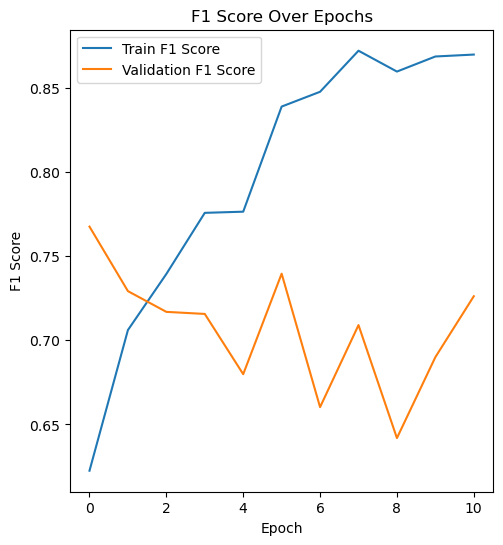

[I 2024-12-18 16:51:35,958] Trial 0 finished with value: 0.7262553572654724 and parameters: {'lstm_units': 126, 'dropout_rate': 0.20622558480782047, 'learning_rate': 0.0007960579883076775, 'batch_size': 96}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.3443 - loss: 1.8400f1 Tensor("truediv_2:0", shape=(), dtype=float32)
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - f1_score_metric: 0.3440 - loss: 1.8334 - val_f1_score_metric: 0.3604 - val_loss: 0.6920
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - f1_score_metric: 0.4266 - loss: 1.5961 - val_f1_score_metric: 0.4041 - val_loss: 0.6725
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - f1_score_metric: 0.4376 - loss: 1.3508 - val_f1_score_metric: 0.4144 - val_loss: 0.6560
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - f1_score_metric: 0.5055 - loss: 1.2619 - val_f1_score_metric: 0.4239 - val_loss: 0.6425
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - f1_score_metric: 0.5104 - loss: 1.1421 - val_f1_score_metric: 0.4626 - val_loss: 0.6320
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - f1_score_metric: 0.5570 - loss: 1.

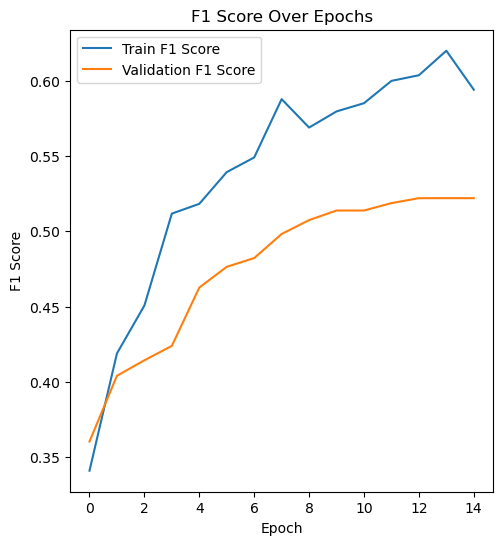

[I 2024-12-18 16:55:36,630] Trial 1 finished with value: 0.5220063924789429 and parameters: {'lstm_units': 62, 'dropout_rate': 0.26743899365925433, 'learning_rate': 3.92815480207914e-05, 'batch_size': 128}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - f1_score_metric: 0.5289 - loss: 1.2004f1 Tensor("truediv_2:0", shape=(), dtype=float32)
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - f1_score_metric: 0.5321 - loss: 1.1869 - val_f1_score_metric: 0.5749 - val_loss: 0.5656
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 981ms/step - f1_score_metric: 0.6471 - loss: 0.8287 - val_f1_score_metric: 0.6122 - val_loss: 0.5493
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 999ms/step - f1_score_metric: 0.7284 - loss: 0.6959 - val_f1_score_metric: 0.6472 - val_loss: 0.5233
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - f1_score_metric: 0.6972 - loss: 0.6850 - val_f1_score_metric: 0.6580 - val_loss: 0.4867
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 987ms/step - f1_score_metric: 0.7155 - loss: 0.6679 - val_f1_score_metric: 0.6617 - val_loss: 0.4710
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 950ms/step - f1_score_metric: 0.7291 

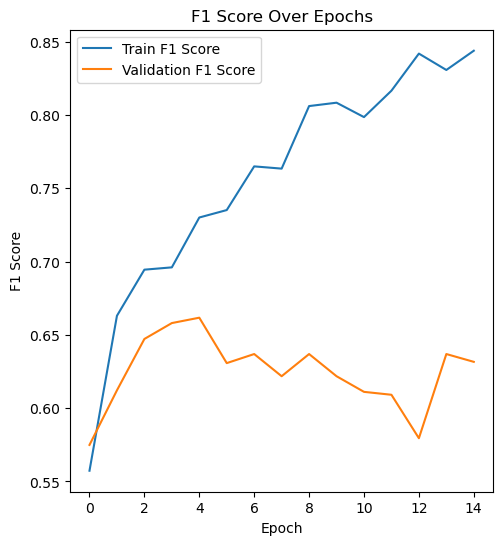

[I 2024-12-18 16:57:44,084] Trial 2 finished with value: 0.6315789222717285 and parameters: {'lstm_units': 30, 'dropout_rate': 0.2265019442522031, 'learning_rate': 0.001137835436206262, 'batch_size': 128}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - f1_score_metric: 0.4895 - loss: 1.2820f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 808ms/step - f1_score_metric: 0.4968 - loss: 1.2670 - val_f1_score_metric: 0.6685 - val_loss: 0.4855
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 794ms/step - f1_score_metric: 0.6123 - loss: 0.8719 - val_f1_score_metric: 0.7045 - val_loss: 0.4054
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 848ms/step - f1_score_metric: 0.6787 - loss: 0.7532 - val_f1_score_metric: 0.7415 - val_loss: 0.3753
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 900ms/step - f1_score_metric: 0.7269 - loss: 0.6600 - val_f1_score_metric: 0.7074 - val_loss: 0.3545
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 880ms/step - f1_score_metric: 0.7457 - loss: 0.6218 - val_f1_score_metric: 0.6006 - val_loss: 0.3471
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 807ms/step - f1

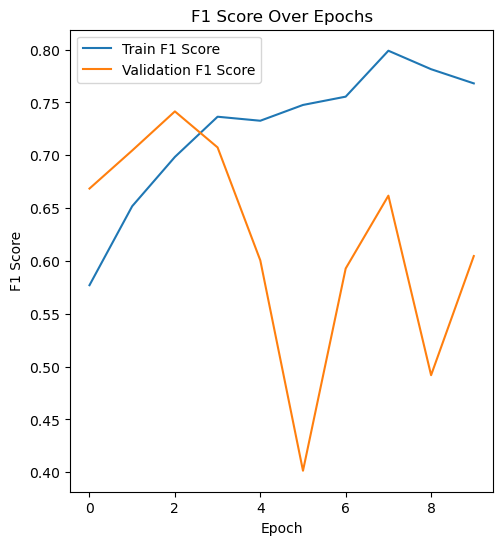

[I 2024-12-18 16:59:22,241] Trial 3 finished with value: 0.6046457290649414 and parameters: {'lstm_units': 30, 'dropout_rate': 0.353657679015733, 'learning_rate': 0.002740708741343239, 'batch_size': 96}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.5367 - loss: 1.1387f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - f1_score_metric: 0.5429 - loss: 1.1275 - val_f1_score_metric: 0.5609 - val_loss: 0.3729
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - f1_score_metric: 0.7098 - loss: 0.7186 - val_f1_score_metric: 0.4308 - val_loss: 0.3339
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - f1_score_metric: 0.7224 - loss: 0.6610 - val_f1_score_metric: 0.4493 - val_loss: 0.3299
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - f1_score_metric: 0.7415 - loss: 0.6031 - val_f1_score_metric: 0.1558 - val_loss: 0.3372
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - f1_score_metric: 0.7435 - loss: 0.5804 - val_f1_score_metric: 0.6071 - val_loss: 0.2919
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - f1_score_metric: 0.7

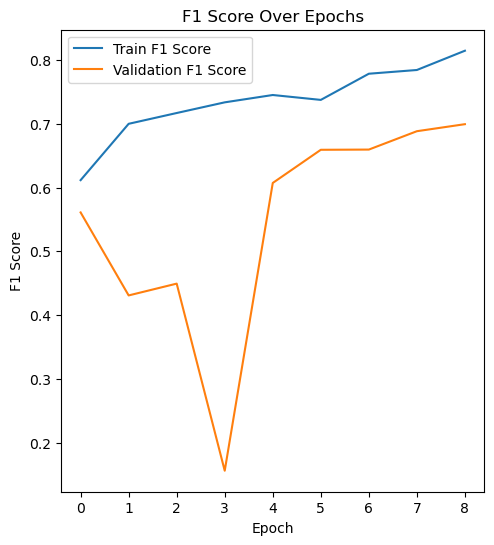

[I 2024-12-18 17:03:58,217] Trial 4 finished with value: 0.6993315815925598 and parameters: {'lstm_units': 94, 'dropout_rate': 0.28756282045118997, 'learning_rate': 0.005666597524267947, 'batch_size': 96}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.4995 - loss: 1.2255f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - f1_score_metric: 0.5014 - loss: 1.2176 - val_f1_score_metric: 0.6013 - val_loss: 0.6191
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - f1_score_metric: 0.6491 - loss: 0.8475 - val_f1_score_metric: 0.6242 - val_loss: 0.6010
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - f1_score_metric: 0.6067 - loss: 0.8486 - val_f1_score_metric: 0.6717 - val_loss: 0.5921
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - f1_score_metric: 0.6400 - loss: 0.7271 - val_f1_score_metric: 0.6912 - val_loss: 0.5665
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - f1_score_metric: 0.6995 - loss: 0.6777 - val_f1_score_metric: 0.6953 - val_loss: 0.5512
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - f1_score_metric: 0.6

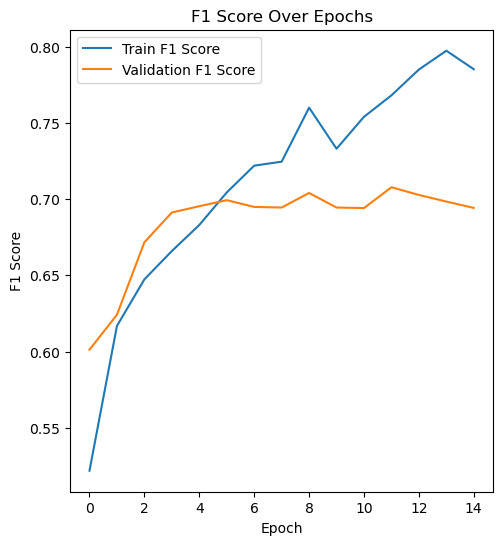

[I 2024-12-18 17:12:03,696] Trial 5 finished with value: 0.6942355036735535 and parameters: {'lstm_units': 94, 'dropout_rate': 0.2426510142804581, 'learning_rate': 0.00013183243694343358, 'batch_size': 96}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score_metric: 0.5053 - loss: 1.1587f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - f1_score_metric: 0.5102 - loss: 1.1490 - val_f1_score_metric: 0.6341 - val_loss: 0.5170
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - f1_score_metric: 0.6430 - loss: 0.7682 - val_f1_score_metric: 0.6799 - val_loss: 0.5006
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - f1_score_metric: 0.7163 - loss: 0.7304 - val_f1_score_metric: 0.6361 - val_loss: 0.4627
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - f1_score_metric: 0.7276 - loss: 0.6780 - val_f1_score_metric: 0.6746 - val_loss: 0.4399
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - f1_score_metric: 0.7466 - loss: 0.6177 - val_f1_score_metric: 0.6682 - val_loss: 0.4190
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - f1_score_metric: 0.7

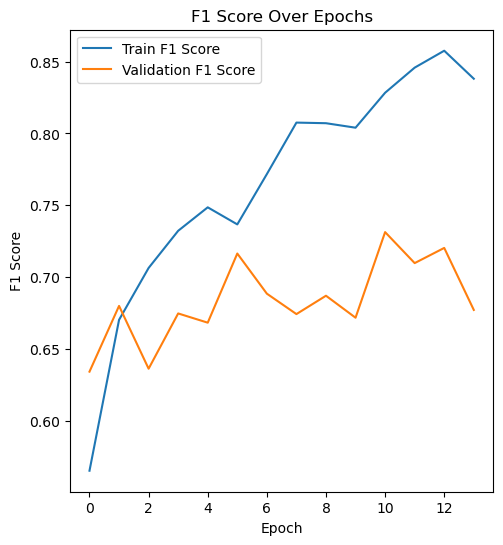

[I 2024-12-18 17:16:18,473] Trial 6 finished with value: 0.6770730018615723 and parameters: {'lstm_units': 62, 'dropout_rate': 0.3302041979999881, 'learning_rate': 0.0007133471581159139, 'batch_size': 96}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.4556 - loss: 1.6261f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - f1_score_metric: 0.4654 - loss: 1.5905 - val_f1_score_metric: 0.7007 - val_loss: 0.4223
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - f1_score_metric: 0.7022 - loss: 0.7257 - val_f1_score_metric: 0.6553 - val_loss: 0.3530
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - f1_score_metric: 0.7001 - loss: 0.7285 - val_f1_score_metric: 0.7316 - val_loss: 0.3292
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - f1_score_metric: 0.7585 - loss: 0.6828 - val_f1_score_metric: 0.6425 - val_loss: 0.3186
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - f1_score_metric: 0.7473 - loss: 0.5680 - val_f1_score_metric: 0.7071 - val_loss: 0.3123
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - f1_score_metric: 0.7

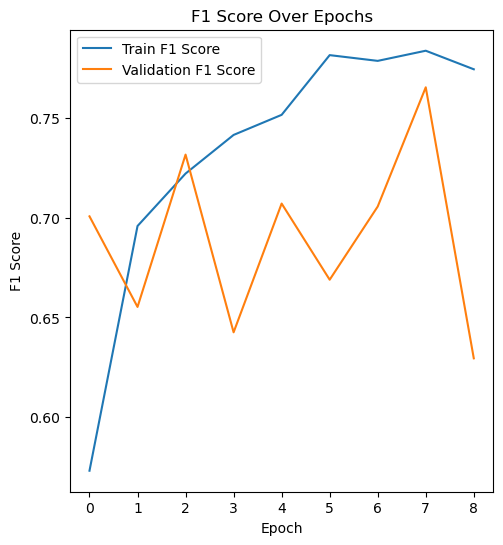

[I 2024-12-18 17:20:46,826] Trial 7 finished with value: 0.629490315914154 and parameters: {'lstm_units': 94, 'dropout_rate': 0.38031168602136334, 'learning_rate': 0.002604171552863375, 'batch_size': 96}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.2529 - loss: 2.1310f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - f1_score_metric: 0.2534 - loss: 2.1231 - val_f1_score_metric: 0.3374 - val_loss: 0.7381
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.3937 - loss: 1.5132 - val_f1_score_metric: 0.4277 - val_loss: 0.6979
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.4698 - loss: 1.2552 - val_f1_score_metric: 0.5105 - val_loss: 0.6656
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.5483 - loss: 1.0887 - val_f1_score_metric: 0.6154 - val_loss: 0.6404
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.6112 - loss: 0.9287 - val_f1_score_metric: 0.6211 - val_loss: 0.6232
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - f1_score_metric: 0.5

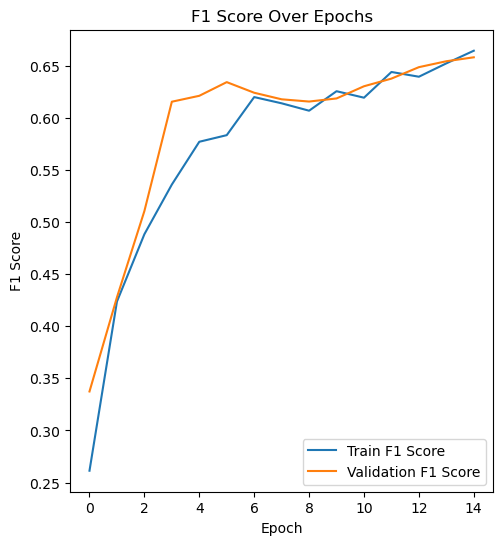

[I 2024-12-18 17:32:14,305] Trial 8 finished with value: 0.65799880027771 and parameters: {'lstm_units': 126, 'dropout_rate': 0.29577082669656357, 'learning_rate': 1.8680050579021803e-05, 'batch_size': 64}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - f1_score_metric: 0.2443 - loss: 1.7784f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 801ms/step - f1_score_metric: 0.2461 - loss: 1.7848 - val_f1_score_metric: 0.2499 - val_loss: 0.6987
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step - f1_score_metric: 0.2651 - loss: 1.8645 - val_f1_score_metric: 0.2528 - val_loss: 0.6972
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 771ms/step - f1_score_metric: 0.2671 - loss: 1.8126 - val_f1_score_metric: 0.2948 - val_loss: 0.6955
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 790ms/step - f1_score_metric: 0.3211 - loss: 1.8331 - val_f1_score_metric: 0.3028 - val_loss: 0.6929
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 775ms/step - f1_score_metric: 0.3114 - loss: 1.7014 - val_f1_score_metric: 0.3144 - val_loss: 0.6909
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 789ms/step - f1_s

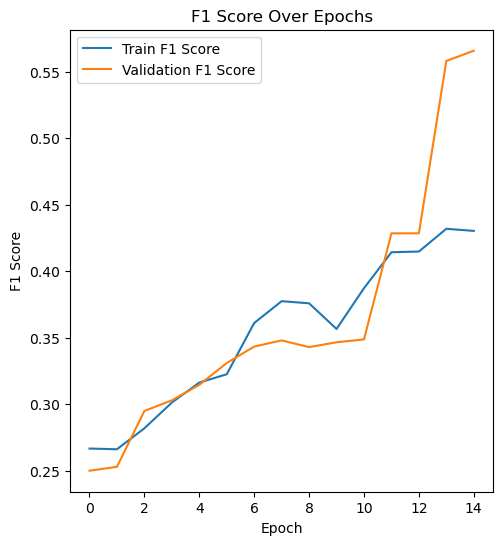

[I 2024-12-18 17:54:11,543] Trial 9 finished with value: 0.5656366944313049 and parameters: {'lstm_units': 30, 'dropout_rate': 0.448604397892303, 'learning_rate': 1.3825758230956736e-05, 'batch_size': 96}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score_metric: 0.5422 - loss: 1.0865f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - f1_score_metric: 0.5430 - loss: 1.0854 - val_f1_score_metric: 0.6579 - val_loss: 0.5399
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - f1_score_metric: 0.6362 - loss: 0.8612 - val_f1_score_metric: 0.7020 - val_loss: 0.5007
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - f1_score_metric: 0.6521 - loss: 0.8052 - val_f1_score_metric: 0.6992 - val_loss: 0.4742
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.6444 - loss: 0.7510 - val_f1_score_metric: 0.6842 - val_loss: 0.4552
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.6739 - loss: 0.7449 - val_f1_score_metric: 0.6873 - val_loss: 0.4476
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.6

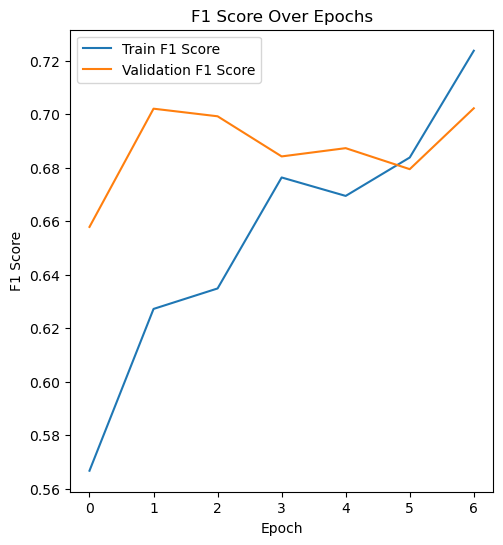

[I 2024-12-18 18:00:34,136] Trial 10 finished with value: 0.70217365026474 and parameters: {'lstm_units': 126, 'dropout_rate': 0.49312767572015515, 'learning_rate': 0.00014380621586156312, 'batch_size': 32}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score_metric: 0.5389 - loss: 1.1683f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - f1_score_metric: 0.5399 - loss: 1.1652 - val_f1_score_metric: 0.6345 - val_loss: 0.5282
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - f1_score_metric: 0.6377 - loss: 0.8066 - val_f1_score_metric: 0.6902 - val_loss: 0.4735
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - f1_score_metric: 0.6923 - loss: 0.7592 - val_f1_score_metric: 0.6740 - val_loss: 0.4224
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.7225 - loss: 0.6707 - val_f1_score_metric: 0.6982 - val_loss: 0.4153
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.7099 - loss: 0.7039 - val_f1_score_metric: 0.7204 - val_loss: 0.3881
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - f1_score_metric: 0.7

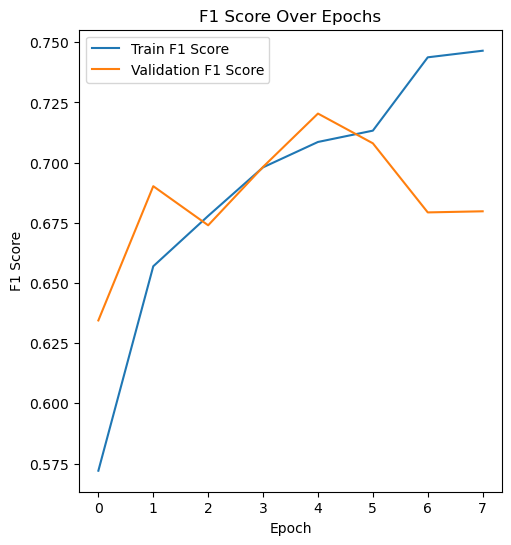

[I 2024-12-18 18:07:58,865] Trial 11 finished with value: 0.6797880530357361 and parameters: {'lstm_units': 126, 'dropout_rate': 0.4935363456560219, 'learning_rate': 0.00023831853013751018, 'batch_size': 32}. Best is trial 0 with value: 0.7262553572654724.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score_metric: 0.5370 - loss: 1.1478f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - f1_score_metric: 0.5383 - loss: 1.1437 - val_f1_score_metric: 0.6444 - val_loss: 0.5297
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - f1_score_metric: 0.6900 - loss: 0.7078 - val_f1_score_metric: 0.7167 - val_loss: 0.4467
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - f1_score_metric: 0.7797 - loss: 0.5682 - val_f1_score_metric: 0.6823 - val_loss: 0.4267
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.7430 - loss: 0.5351 - val_f1_score_metric: 0.6494 - val_loss: 0.3919
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.7518 - loss: 0.5274 - val_f1_score_metric: 0.6616 - val_loss: 0.3556
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - f1_score_metric: 0.7

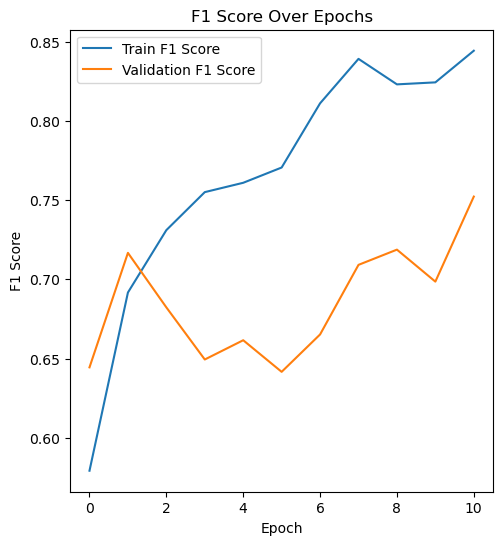

[I 2024-12-18 18:18:37,165] Trial 12 finished with value: 0.7522019147872925 and parameters: {'lstm_units': 126, 'dropout_rate': 0.20057389211134663, 'learning_rate': 0.00046046864922309993, 'batch_size': 32}. Best is trial 12 with value: 0.7522019147872925.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.5150 - loss: 1.2514f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - f1_score_metric: 0.5192 - loss: 1.2390 - val_f1_score_metric: 0.6903 - val_loss: 0.5508
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - f1_score_metric: 0.6600 - loss: 0.8328 - val_f1_score_metric: 0.6497 - val_loss: 0.5229
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - f1_score_metric: 0.7496 - loss: 0.6342 - val_f1_score_metric: 0.7172 - val_loss: 0.4480
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - f1_score_metric: 0.7695 - loss: 0.5982 - val_f1_score_metric: 0.7103 - val_loss: 0.4344
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - f1_score_metric: 0.8113 - loss: 0.4806 - val_f1_score_metric: 0.7035 - val_loss: 0.4218
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.8

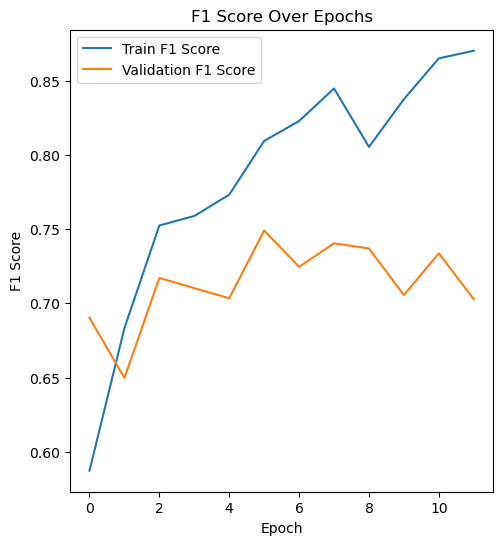

[I 2024-12-18 18:27:19,371] Trial 13 finished with value: 0.7027971744537354 and parameters: {'lstm_units': 126, 'dropout_rate': 0.20442307915455696, 'learning_rate': 0.0005740250794405474, 'batch_size': 64}. Best is trial 12 with value: 0.7522019147872925.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.3867 - loss: 1.5186f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - f1_score_metric: 0.3909 - loss: 1.5051 - val_f1_score_metric: 0.6678 - val_loss: 0.6161
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - f1_score_metric: 0.5904 - loss: 0.9343 - val_f1_score_metric: 0.6802 - val_loss: 0.5951
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - f1_score_metric: 0.6039 - loss: 0.9194 - val_f1_score_metric: 0.6932 - val_loss: 0.5854
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - f1_score_metric: 0.6421 - loss: 0.8441 - val_f1_score_metric: 0.7050 - val_loss: 0.5745
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - f1_score_metric: 0.6782 - loss: 0.7798 - val_f1_score_metric: 0.7009 - val_loss: 0.5548
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - f1_score_metric: 0.6

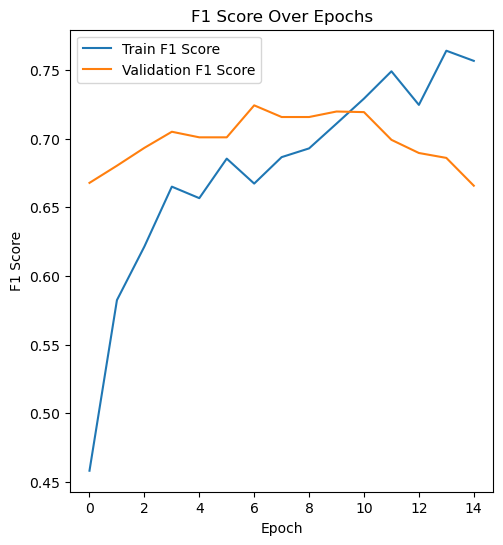

[I 2024-12-18 18:35:39,453] Trial 14 finished with value: 0.6656862497329712 and parameters: {'lstm_units': 94, 'dropout_rate': 0.2020676052906629, 'learning_rate': 7.273652142793822e-05, 'batch_size': 64}. Best is trial 12 with value: 0.7522019147872925.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score_metric: 0.5003 - loss: 1.0964f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - f1_score_metric: 0.5029 - loss: 1.0925 - val_f1_score_metric: 0.6990 - val_loss: 0.4943
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - f1_score_metric: 0.6790 - loss: 0.7331 - val_f1_score_metric: 0.7182 - val_loss: 0.4786
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - f1_score_metric: 0.7045 - loss: 0.6336 - val_f1_score_metric: 0.6592 - val_loss: 0.4278
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.7560 - loss: 0.5354 - val_f1_score_metric: 0.7185 - val_loss: 0.4026
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.7734 - loss: 0.5159 - val_f1_score_metric: 0.6946 - val_loss: 0.3421
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1_score_metric: 0.7

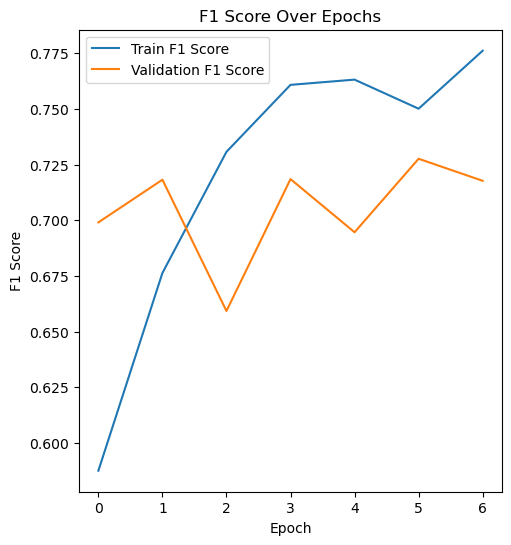

[I 2024-12-18 18:42:03,840] Trial 15 finished with value: 0.7177136540412903 and parameters: {'lstm_units': 126, 'dropout_rate': 0.2534834553444294, 'learning_rate': 0.00041084014546127973, 'batch_size': 32}. Best is trial 12 with value: 0.7522019147872925.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.5250 - loss: 1.2541f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - f1_score_metric: 0.5285 - loss: 1.2430 - val_f1_score_metric: 0.6458 - val_loss: 0.4346
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - f1_score_metric: 0.6242 - loss: 0.9707 - val_f1_score_metric: 0.6584 - val_loss: 0.3774
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.7147 - loss: 0.6383 - val_f1_score_metric: 0.6649 - val_loss: 0.3503
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - f1_score_metric: 0.7351 - loss: 0.6461 - val_f1_score_metric: 0.4609 - val_loss: 0.3362
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - f1_score_metric: 0.7353 - loss: 0.6630 - val_f1_score_metric: 0.6273 - val_loss: 0.2957
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.7

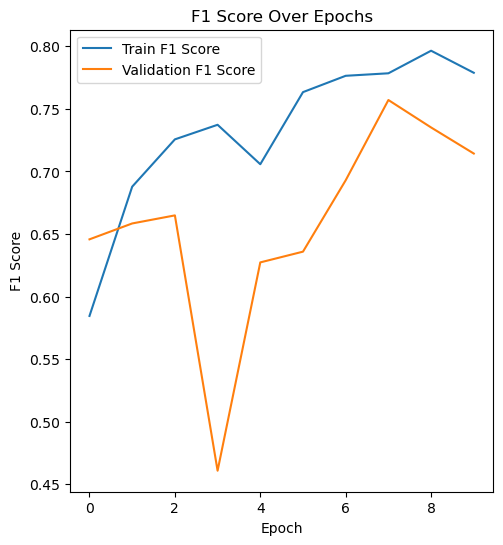

[I 2024-12-18 18:49:20,580] Trial 16 finished with value: 0.714285671710968 and parameters: {'lstm_units': 126, 'dropout_rate': 0.4020969202454776, 'learning_rate': 0.001333155394799229, 'batch_size': 64}. Best is trial 12 with value: 0.7522019147872925.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.4906 - loss: 1.3654f1 Tensor("truediv_2:0", shape=(), dtype=float32)
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - f1_score_metric: 0.4999 - loss: 1.3402 - val_f1_score_metric: 0.5626 - val_loss: 0.4210
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - f1_score_metric: 0.7009 - loss: 0.7769 - val_f1_score_metric: 0.6333 - val_loss: 0.3602
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - f1_score_metric: 0.6836 - loss: 0.7537 - val_f1_score_metric: 0.6031 - val_loss: 0.3536
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - f1_score_metric: 0.7437 - loss: 0.5964 - val_f1_score_metric: 0.6258 - val_loss: 0.3341
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - f1_score_metric: 0.7580 - loss: 0.5823 - val_f1_score_metric: 0.4958 - val_loss: 0.3243
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - f1_score_metric: 0.7601 - loss: 0.

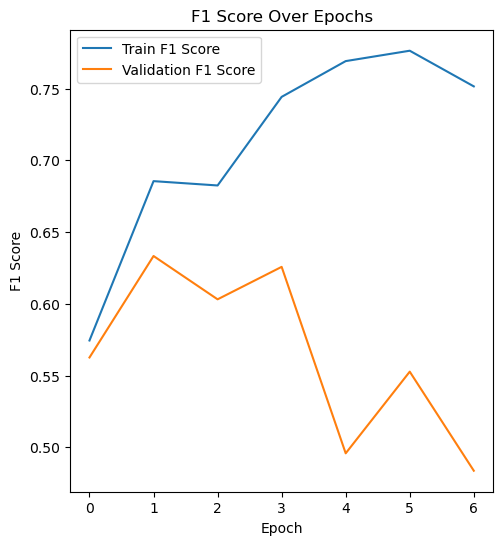

[I 2024-12-18 18:51:06,825] Trial 17 finished with value: 0.48368293046951294 and parameters: {'lstm_units': 62, 'dropout_rate': 0.3135876741109235, 'learning_rate': 0.007555127008874884, 'batch_size': 128}. Best is trial 12 with value: 0.7522019147872925.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score_metric: 0.5182 - loss: 1.2800f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - f1_score_metric: 0.5195 - loss: 1.2740 - val_f1_score_metric: 0.6592 - val_loss: 0.5563
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - f1_score_metric: 0.6881 - loss: 0.7371 - val_f1_score_metric: 0.6888 - val_loss: 0.5074
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - f1_score_metric: 0.6521 - loss: 0.7030 - val_f1_score_metric: 0.6279 - val_loss: 0.4777
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - f1_score_metric: 0.7264 - loss: 0.5799 - val_f1_score_metric: 0.6644 - val_loss: 0.4586
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - f1_score_metric: 0.6678 - loss: 0.6377 - val_f1_score_metric: 0.6762 - val_loss: 0.4361
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - f1_score_metric: 0.7

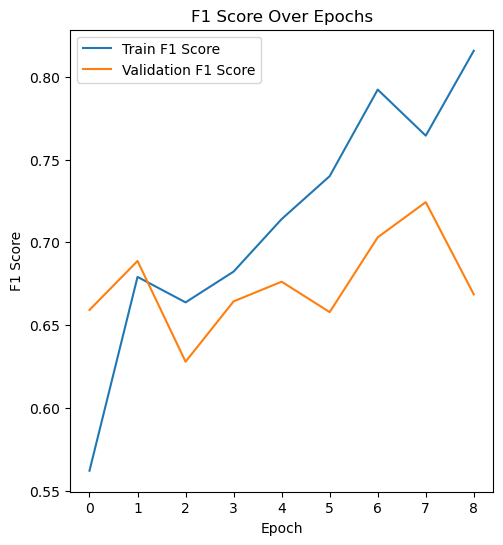

[I 2024-12-18 18:58:33,592] Trial 18 finished with value: 0.6685675978660583 and parameters: {'lstm_units': 94, 'dropout_rate': 0.2301285213570168, 'learning_rate': 0.0002255320037668398, 'batch_size': 32}. Best is trial 12 with value: 0.7522019147872925.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.5557 - loss: 1.2120f1 Tensor("truediv_2:0", shape=(), dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - f1_score_metric: 0.5584 - loss: 1.2003 - val_f1_score_metric: 0.6365 - val_loss: 0.3620
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - f1_score_metric: 0.6863 - loss: 0.7358 - val_f1_score_metric: 0.5388 - val_loss: 0.3547
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - f1_score_metric: 0.7357 - loss: 0.5778 - val_f1_score_metric: 0.3836 - val_loss: 0.3534
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - f1_score_metric: 0.7680 - loss: 0.5667 - val_f1_score_metric: 0.5227 - val_loss: 0.2993
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.7566 - loss: 0.4733 - val_f1_score_metric: 0.6085 - val_loss: 0.3075
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - f1_score_metric: 0.7

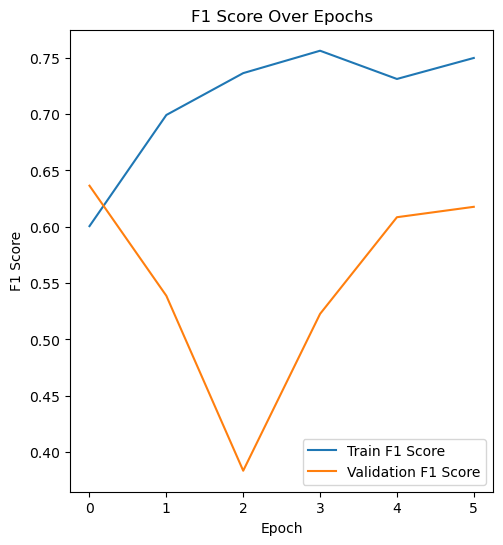

[I 2024-12-18 19:02:37,463] Trial 19 finished with value: 0.6177248358726501 and parameters: {'lstm_units': 126, 'dropout_rate': 0.28108113732317386, 'learning_rate': 0.002347802602071375, 'batch_size': 64}. Best is trial 12 with value: 0.7522019147872925.


Best trial:
  Value (F1 score): 0.7522019147872925
  Params:
    lstm_units: 126
    dropout_rate: 0.20057389211134663
    learning_rate: 0.00046046864922309993
    batch_size: 32
Best hyperparameters: {'lstm_units': 126, 'dropout_rate': 0.20057389211134663, 'learning_rate': 0.00046046864922309993, 'batch_size': 32}
Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.5348 - loss: 0.6378f1 Tensor("truediv_2:0", shape=(), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - f1_score_metric: 0.5375 - loss: 0.6347 - val_f1_score_metric: 0.6307 - val_loss: 0.5217
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - f1_score_metric: 0.6902 - loss: 0.4273 - val_f1_score_metric: 0.6551 - val_loss: 0.4551
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - f1_score_metric: 0.7676 - loss: 0.3430 - val_f1_score_metric: 0.5727 - val_loss: 0.4348
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━

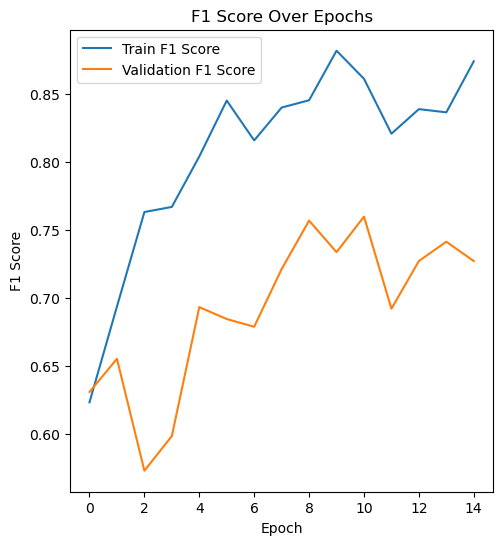

In [10]:
from optuna.samplers import TPESampler

# Convert PyTorch DataLoader data to NumPy (you should already have this done before)
x_train_np, y_train_np = data_loader_to_numpy(train_data_loader)
x_val_np, y_val_np = data_loader_to_numpy(val_data_loader)

# Replace NaN values in x_train and x_val
x_train_np = replace_nans_with_mean(x_train_np)
x_val_np = replace_nans_with_mean(x_val_np)

input_shape = (x_train_np.shape[1], x_train_np.shape[2])  # (time_steps, features)
sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
# Perform the hyperparameter optimization

study = optuna.create_study(direction='maximize', sampler=sampler)  # We want to maximize the F1 score
study.optimize(lambda trial: objective(trial, x_train_np, y_train_np, x_val_np, y_val_np, input_shape), n_trials=20)

# Print the best trial's hyperparameters and performance
print("Best trial:")
trial = study.best_trial
print(f"  Value (F1 score): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Get the best hyperparameters
best_params = trial.params
print(f"Best hyperparameters: {best_params}")

# Train the model using the best hyperparameters

model = get_classification_model(input_shape, best_params['lstm_units'], best_params['dropout_rate'], best_params['learning_rate'])
history = model.fit(x_train_np, y_train_np, epochs=15, batch_size=best_params['batch_size'], validation_data=(x_val_np, y_val_np))

# Plot training and validation metrics
plot_metrics(history)

We then test the model on the best performing parameters we selected using optuna. We will also plot a confusion matrix that will be used for analysis of the results




7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step
Test Loss: 0.4444141387939453
Test F1 Score: 0.6196006536483765
{'loss': 0.4444141387939453, 'f1_score': 0.6196006536483765}
Confusion matrix plot saved to plots_results/cm_BI_LSTM_ss_tw022.png


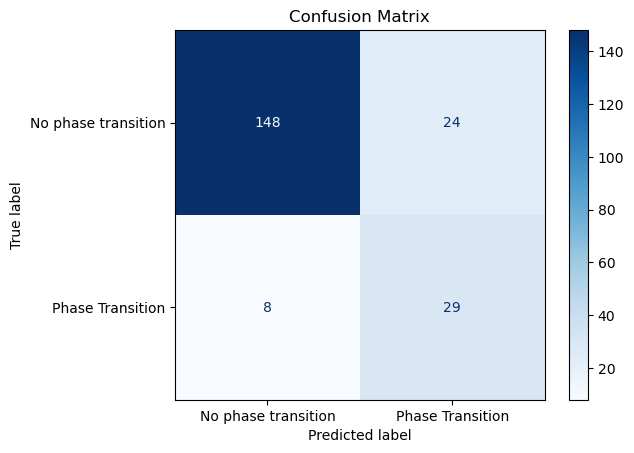

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_model(model, x_test, y_test):
    """
    Evaluate the trained model on the test data and compute relevant metrics.

    Args:
        model (keras.Model): Trained Keras model.
        x_test (np.ndarray): Test features, shape=(N, time_steps, features).
        y_test (np.ndarray): True test labels, shape=(N,).

    Returns:
        dict: A dictionary containing the loss, accuracy, and F1 score.
    """
    # Evaluate the model on the test set
    loss, f1 = model.evaluate(x_test, y_test, verbose=0)

    print(f"Test Loss: {loss}")
    print(f"Test F1 Score: {f1}")

    # Return metrics in a dictionary
    return {"loss": loss, "f1_score": f1}

def plot_confusion_matrix(y_true, y_pred, class_names,save_path):
    """
    Plot and display a confusion matrix.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        class_names (list): List of class names.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    # Save the plot
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Confusion matrix plot saved to {save_path}")
    plt.show()

# Convert test DataLoader to numpy arrays
x_test_np, y_test_np = data_loader_to_numpy(test_data_loader)
x_test_np = replace_nans_with_mean(x_test_np)

# Check for NaN or Inf values
if np.any(np.isnan(x_test_np)) or np.any(np.isinf(x_test_np)):
    print("NaN or Inf values found in x_test")

# Predict
y_pred_np = model.predict(x_test_np)
y_pred_np = np.round(y_pred_np).flatten()  # Ensure predictions are binary

# Evaluate the model
test_results = test_model(model, x_test_np, y_test_np)

print(test_results)

# Plot the confusion matrix
class_names = ["No phase transition", "Phase Transition"]
plot_confusion_matrix(y_test_np, y_pred_np, class_names,"plots_results/cm_BI_LSTM_ss_tw022.png")

